In [31]:
# Import necessary libraries
import os
os.chdir("C:/Users/Pauli/OneDrive/Dokumente/Uni/Masterarbeit/code/preprocessing")
import pandas as pd
import numpy as np
import pickle
#nn modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

#metrics and plotting
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
#other
from datasplit import get_datasplit
from featurescaling import scale_features
from earlystopper import EarlyStopper
import copy


In [64]:
#load necessary data
#open multi index pickle file
with open("data_split_multiind.pkl", "rb") as f:
    [ind_train, ind_val, ind_test, ind_holdout] = pickle.load(f)

#Load Kinase-ligand-K_off dataset
df_target_value = pd.read_excel("kinase_ligand_k_off.xlsx", sheet_name='kinase_ligand_k_off')
df_target_value = df_target_value.dropna(subset=["log_koff"])  #drop rows with missing target value

#choose if full or pocket kinase sequences
feature_set_kinase = "Sequences_propy"   # "Sequences_propy" or "Pocket_Sequences_propy"
feature_set_ligand = "Morgan_Fingerprints"  # "Mordred_Features" or "Morgan_Fingerprints"

#prepare feature dataframe
    
df_ligand = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Ligand_Morgan_Fingerprints")
df_kinase = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Kinase_"+feature_set_kinase)

    
#merge dataframes
df = pd.merge(df_target_value, df_ligand, on="ligand", how="left") 
df_all = pd.merge(df, df_kinase, on="kinase", how="left")
df_all.dropna(subset=["log_koff"], inplace=True)  #drop rows with missing target value

#get iris split from my cleaned data set
df_train = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_train)].copy()
df_val = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_val)].copy()
df_test = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_test)].copy()
df_holdout = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_holdout)].copy()
#merge train and val for final training
df_train = pd.merge(df_train, df_val, how="outer")

In [65]:
ligand_selectors = {
    "Mordred_Features":      lambda df: df.loc[:, "ABC":"mZagreb2"],
    "Morgan_Fingerprints":   lambda df: df.loc[:, "morgan__0":"morgan__2047"],
    None:                    lambda df: df.iloc[:, 0:0],  # empty
}

kinase_selectors = {
    "ascii":                     lambda df: df.loc[:, "0":"84"],          # columns named "0".."84"
    "Sequences_propy":           lambda df: df.loc[:, "AAC":"APAAC"],
    "Pocket_Sequences_propy":    lambda df: df.loc[:, "AAC":"APAAC"],
    None:                        lambda df: df.iloc[:, 0:0],  # empty
}

In [66]:
ligand_cols = ligand_selectors[feature_set_ligand](df_train).columns.tolist()
kinase_cols = kinase_selectors[feature_set_kinase](df_train).columns.tolist()

#set feature_range for scalers if mordred
if feature_set_ligand == "Mordred_Features":
    feature_range = (-1, 1)
else:
    feature_range = (0, 1)


Iteration through all of the Features

In [67]:
#feature columns
extra_features = ["AAC", "DPC", "TPC", "MBauto", "Moranauto",
                  "Gearyauto", "CTD", "SOCN", "QSO", "PAAC", "APAAC"]

#scalar fitting for target value
y_raw = df_train["log_koff"].values.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaler.fit(y_raw)


MinMaxScaler()

In [68]:
import ast
def parse_list_cell(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)   # safe parsing of stringified list
        except Exception:
            return np.nan
    return x  # already a list/sequence

#df_train["AAC"] = df_train["AAC"].apply(parse_list_cell)


Using feature: AAC
Using unscaled Morgan Fingerprints for ligands.
Using unscaled Morgan Fingerprints for ligands.
Epoch 1/100, Train Loss: 0.0499, Val Loss: 0.0227
Epoch 2/100, Train Loss: 0.0238, Val Loss: 0.0231
Epoch 3/100, Train Loss: 0.0230, Val Loss: 0.0214
Epoch 4/100, Train Loss: 0.0219, Val Loss: 0.0202
Epoch 5/100, Train Loss: 0.0218, Val Loss: 0.0202
Epoch 6/100, Train Loss: 0.0211, Val Loss: 0.0228
Epoch 7/100, Train Loss: 0.0213, Val Loss: 0.0230
Epoch 8/100, Train Loss: 0.0208, Val Loss: 0.0208
Epoch 9/100, Train Loss: 0.0201, Val Loss: 0.0195
Epoch 10/100, Train Loss: 0.0202, Val Loss: 0.0193
Epoch 11/100, Train Loss: 0.0192, Val Loss: 0.0196
Epoch 12/100, Train Loss: 0.0195, Val Loss: 0.0205
Epoch 13/100, Train Loss: 0.0191, Val Loss: 0.0192
Epoch 14/100, Train Loss: 0.0182, Val Loss: 0.0204
Epoch 15/100, Train Loss: 0.0186, Val Loss: 0.0199
Epoch 16/100, Train Loss: 0.0179, Val Loss: 0.0194
Epoch 17/100, Train Loss: 0.0177, Val Loss: 0.0186
Epoch 18/100, Train Loss: 0

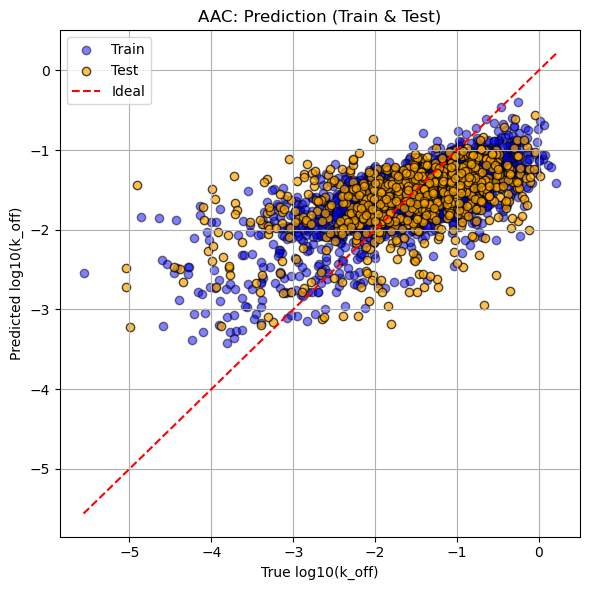

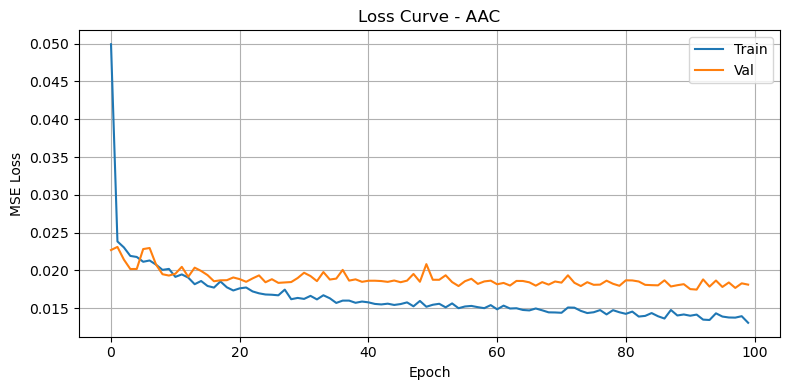

Using feature: DPC
Using unscaled Morgan Fingerprints for ligands.
Using unscaled Morgan Fingerprints for ligands.
Epoch 1/100, Train Loss: 0.0434, Val Loss: 0.0145
Epoch 2/100, Train Loss: 0.0161, Val Loss: 0.0140
Epoch 3/100, Train Loss: 0.0151, Val Loss: 0.0149
Epoch 4/100, Train Loss: 0.0156, Val Loss: 0.0145
Epoch 5/100, Train Loss: 0.0152, Val Loss: 0.0129
Epoch 6/100, Train Loss: 0.0143, Val Loss: 0.0130
Epoch 7/100, Train Loss: 0.0136, Val Loss: 0.0127
Epoch 8/100, Train Loss: 0.0135, Val Loss: 0.0192
Epoch 9/100, Train Loss: 0.0138, Val Loss: 0.0147
Epoch 10/100, Train Loss: 0.0133, Val Loss: 0.0169
Epoch 11/100, Train Loss: 0.0134, Val Loss: 0.0136
Epoch 12/100, Train Loss: 0.0127, Val Loss: 0.0161
Epoch 13/100, Train Loss: 0.0123, Val Loss: 0.0123
Epoch 14/100, Train Loss: 0.0127, Val Loss: 0.0141
Epoch 15/100, Train Loss: 0.0119, Val Loss: 0.0138
Epoch 16/100, Train Loss: 0.0118, Val Loss: 0.0187
Epoch 17/100, Train Loss: 0.0115, Val Loss: 0.0125
Epoch 18/100, Train Loss: 0

In [ ]:
#model
dropout_ratio = 0.3

class NN_regression(nn.Module):
    def __init__(self, in_len, out_len=1, dropout_ratio=dropout_ratio):
        super().__init__()
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1 = nn.Linear(in_len, 256)
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, out_len)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.layer1(x))
        x = self.dropout2(x)
        x = F.relu(self.layer2(x))
        return self.output(x)

results = []
all_loss_curves = {}

for feature_name in extra_features:
    print(f"Using feature: {feature_name}")

    # Extract and scale only the protein features from the TRAIN dataframe!
    X_ligand_train = df_train[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
    X_kinase_train = df_train[feature_name].apply(parse_list_cell).tolist()
    x_scaler_ligand = MinMaxScaler(feature_range).fit(X_ligand_train)
    x_scaler_kinase = MinMaxScaler(feature_range).fit(X_kinase_train)

    

    def prepare_tensors(df, scaler_ligand, scaler_kinase):
        y = (df["log_koff"].values).reshape(-1, 1)
        y_scaled = y_scaler.transform(y)
        if feature_set_ligand=="Morgan_Fingerprints":
            X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
            X_kinase = df[feature_name].apply(parse_list_cell).tolist()
            X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
            X = np.hstack([X_scaled_kinase, X_ligand])
            print("Using unscaled Morgan Fingerprints for ligands.")
        else:
            X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
            X_kinase = df[feature_name].apply(parse_list_cell).tolist()
            X_scaled_ligand = x_scaler_ligand.transform(X_ligand)
            X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
            X =  np.hstack([X_scaled_kinase, X_scaled_ligand])
            
        X_tensor = torch.tensor(X, dtype=torch.float32) # Konvertieren in Tensoren
        y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
        return TensorDataset(X_tensor, y_tensor)




    train_ds = prepare_tensors(df_train, scaler_ligand=x_scaler_ligand, scaler_kinase=x_scaler_kinase)
    test_ds = prepare_tensors(df_test, scaler_ligand=x_scaler_ligand, scaler_kinase=x_scaler_kinase)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


    model = NN_regression(in_len=train_ds.tensors[0].shape[1]) #model initializing!
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #adam optimizer, learning rate = 0.001
    loss_fn = nn.MSELoss() #loss function
    #early_stopper = EarlyStopper(patience=10, min_delta=0.0001) #standard min_delta is 0.001


    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_model_path = f"best_model_{feature_name}.pt"

    for epoch in range(100):  # n_epochs, so far 100 is the best
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad() #reset gradients
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in test_loader) / len(test_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch {epoch+1}/100, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")
        
        #if early_stopper.early_stop(val_loss):
         #   print(f"EarlyStopper triggered at epoch {epoch+1}")
          #  break



    model.load_state_dict(torch.load(best_model_path)) #loading my best model



    model.eval()
    with torch.no_grad():
        # Test predictions
        y_test_pred_scaled = model(test_ds.tensors[0]).numpy()
        y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
        y_test_true = y_scaler.inverse_transform(test_ds.tensors[1].numpy())

        # Train predictions
        y_train_pred_scaled = model(train_ds.tensors[0]).numpy()
        y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
        y_train_true = y_scaler.inverse_transform(train_ds.tensors[1].numpy())

    mae = mean_absolute_error(y_test_true, y_test_pred)
    r2 = r2_score(y_test_true, y_test_pred)

    results.append({
        "Feature": feature_name,
        "Best Epoch": np.argmin(val_losses) + 1,
        "Train Loss": train_losses[-1],
        "Validation Loss": min(val_losses),
        "MAE": mae,
        "R2": r2
    })
    all_loss_curves[feature_name] = {"train": train_losses, "val": val_losses}


#scatter plot of predicted vs true values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Train', c='blue', edgecolors='k')
    plt.scatter(y_test_true, y_test_pred, alpha=0.7, label='Test', c='orange', edgecolors='k')
    min_val = min(y_train_true.min(), y_test_true.min())
    max_val = max(y_train_true.max(), y_test_true.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
    plt.xlabel("True log10(k_off)")
    plt.ylabel("Predicted log10(k_off)")
    plt.title(f"{feature_name}: Prediction (Train & Test)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#loss plot
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.title(f"Loss Curve - {feature_name}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    os.remove(best_model_path)  # cleanup

#table with the results
results_df = pd.DataFrame(results)
print(results_df)

#plotting all of the loss functions
plt.figure(figsize=(10, 6))
for feat, curves in all_loss_curves.items():
    plt.plot(curves["val"], label=f"{feat}")
plt.title("Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()
